Cyna Shirazinejad, 7/7/21

# Notebook 15: analyze scission-present ARPC3+ CCPs, 'zero' padding

outline:
* comparison of lifetimes of ARPC3+/- CCPs
* comparison of aligned intensities of ARPC3+/- CCPs

##### import all necessary Python modules

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt
import pickle
from IPython.display import Image
from scipy import signal
import scipy.stats as stats
import seaborn as sns

analysis_metadata = np.load('analysis_metadata.npy', allow_pickle=True)
sys.path.append(analysis_metadata.item().get('path_notebook')+'/cmeAnalysisPostProcessingSimplified') # add custom Python scripts to the local path
import generate_index_dictionary
import return_track_attributes
import display_tracks
index_dictionary = generate_index_dictionary.return_index_dictionary()

In [2]:
from scipy.fft import rfft, rfftfreq
from scipy import signal

# load files

In [3]:
experiment = 'ada_wildtype'

In [4]:
path_outputs = analysis_metadata.item().get('path_outputs')

In [5]:
with open(path_outputs+'/dataframes/'+experiment+'_merged_ccp_attributes', 'rb') as f:
    merged_results = pickle.load(f)  

    
sig_arpc3_dnm2_peak = merged_results['significant_arpc3_at_dnm2_peak_arpc3_positive']
indices_sig_arpc3_dnm2_peak = np.where(np.array(sig_arpc3_dnm2_peak)==1)[0]

time_ap2_appearance_to_dnm2_peak_arpc3_negative = merged_results['time_ap2_appearance_to_dnm2_peak_arpc3_negative']
time_ap2_appearance_to_dnm2_peak_arpc3_positive = np.array(merged_results['time_ap2_appearance_to_dnm2_peak_arpc3_positive'])[indices_sig_arpc3_dnm2_peak]

# merge amplitudes of different channels

In [7]:
ap2_amplitudes_arpc3_negative = []
for i in range(len(merged_results['ch0_vectors_arpc3_negative'])):
    ap2_amplitudes_arpc3_negative.append(merged_results['ch0_vectors_arpc3_negative'][i])

ap2_amplitudes_arpc3_positive = []
for i in range(len(merged_results['ch0_vectors_arpc3_positive'])):
    ap2_amplitudes_arpc3_positive.append(merged_results['ch0_vectors_arpc3_positive'][i])
ap2_amplitudes_arpc3_positive = np.array(ap2_amplitudes_arpc3_positive)[indices_sig_arpc3_dnm2_peak]

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [9]:
all_ap2_signal = []

for i in range(len(ap2_amplitudes_arpc3_negative)): # stack all DNM2 intensities

    all_ap2_signal += list(ap2_amplitudes_arpc3_negative[i])

In [10]:
dt = 1 # sampling interval

FFT = rfft(all_ap2_signal) # real FFT of DNM2 signals

# Getting the related frequencies
freqs = rfftfreq(len(all_ap2_signal), dt)

Text(0.5, 1.0, 'FFT vs sample frequencies')

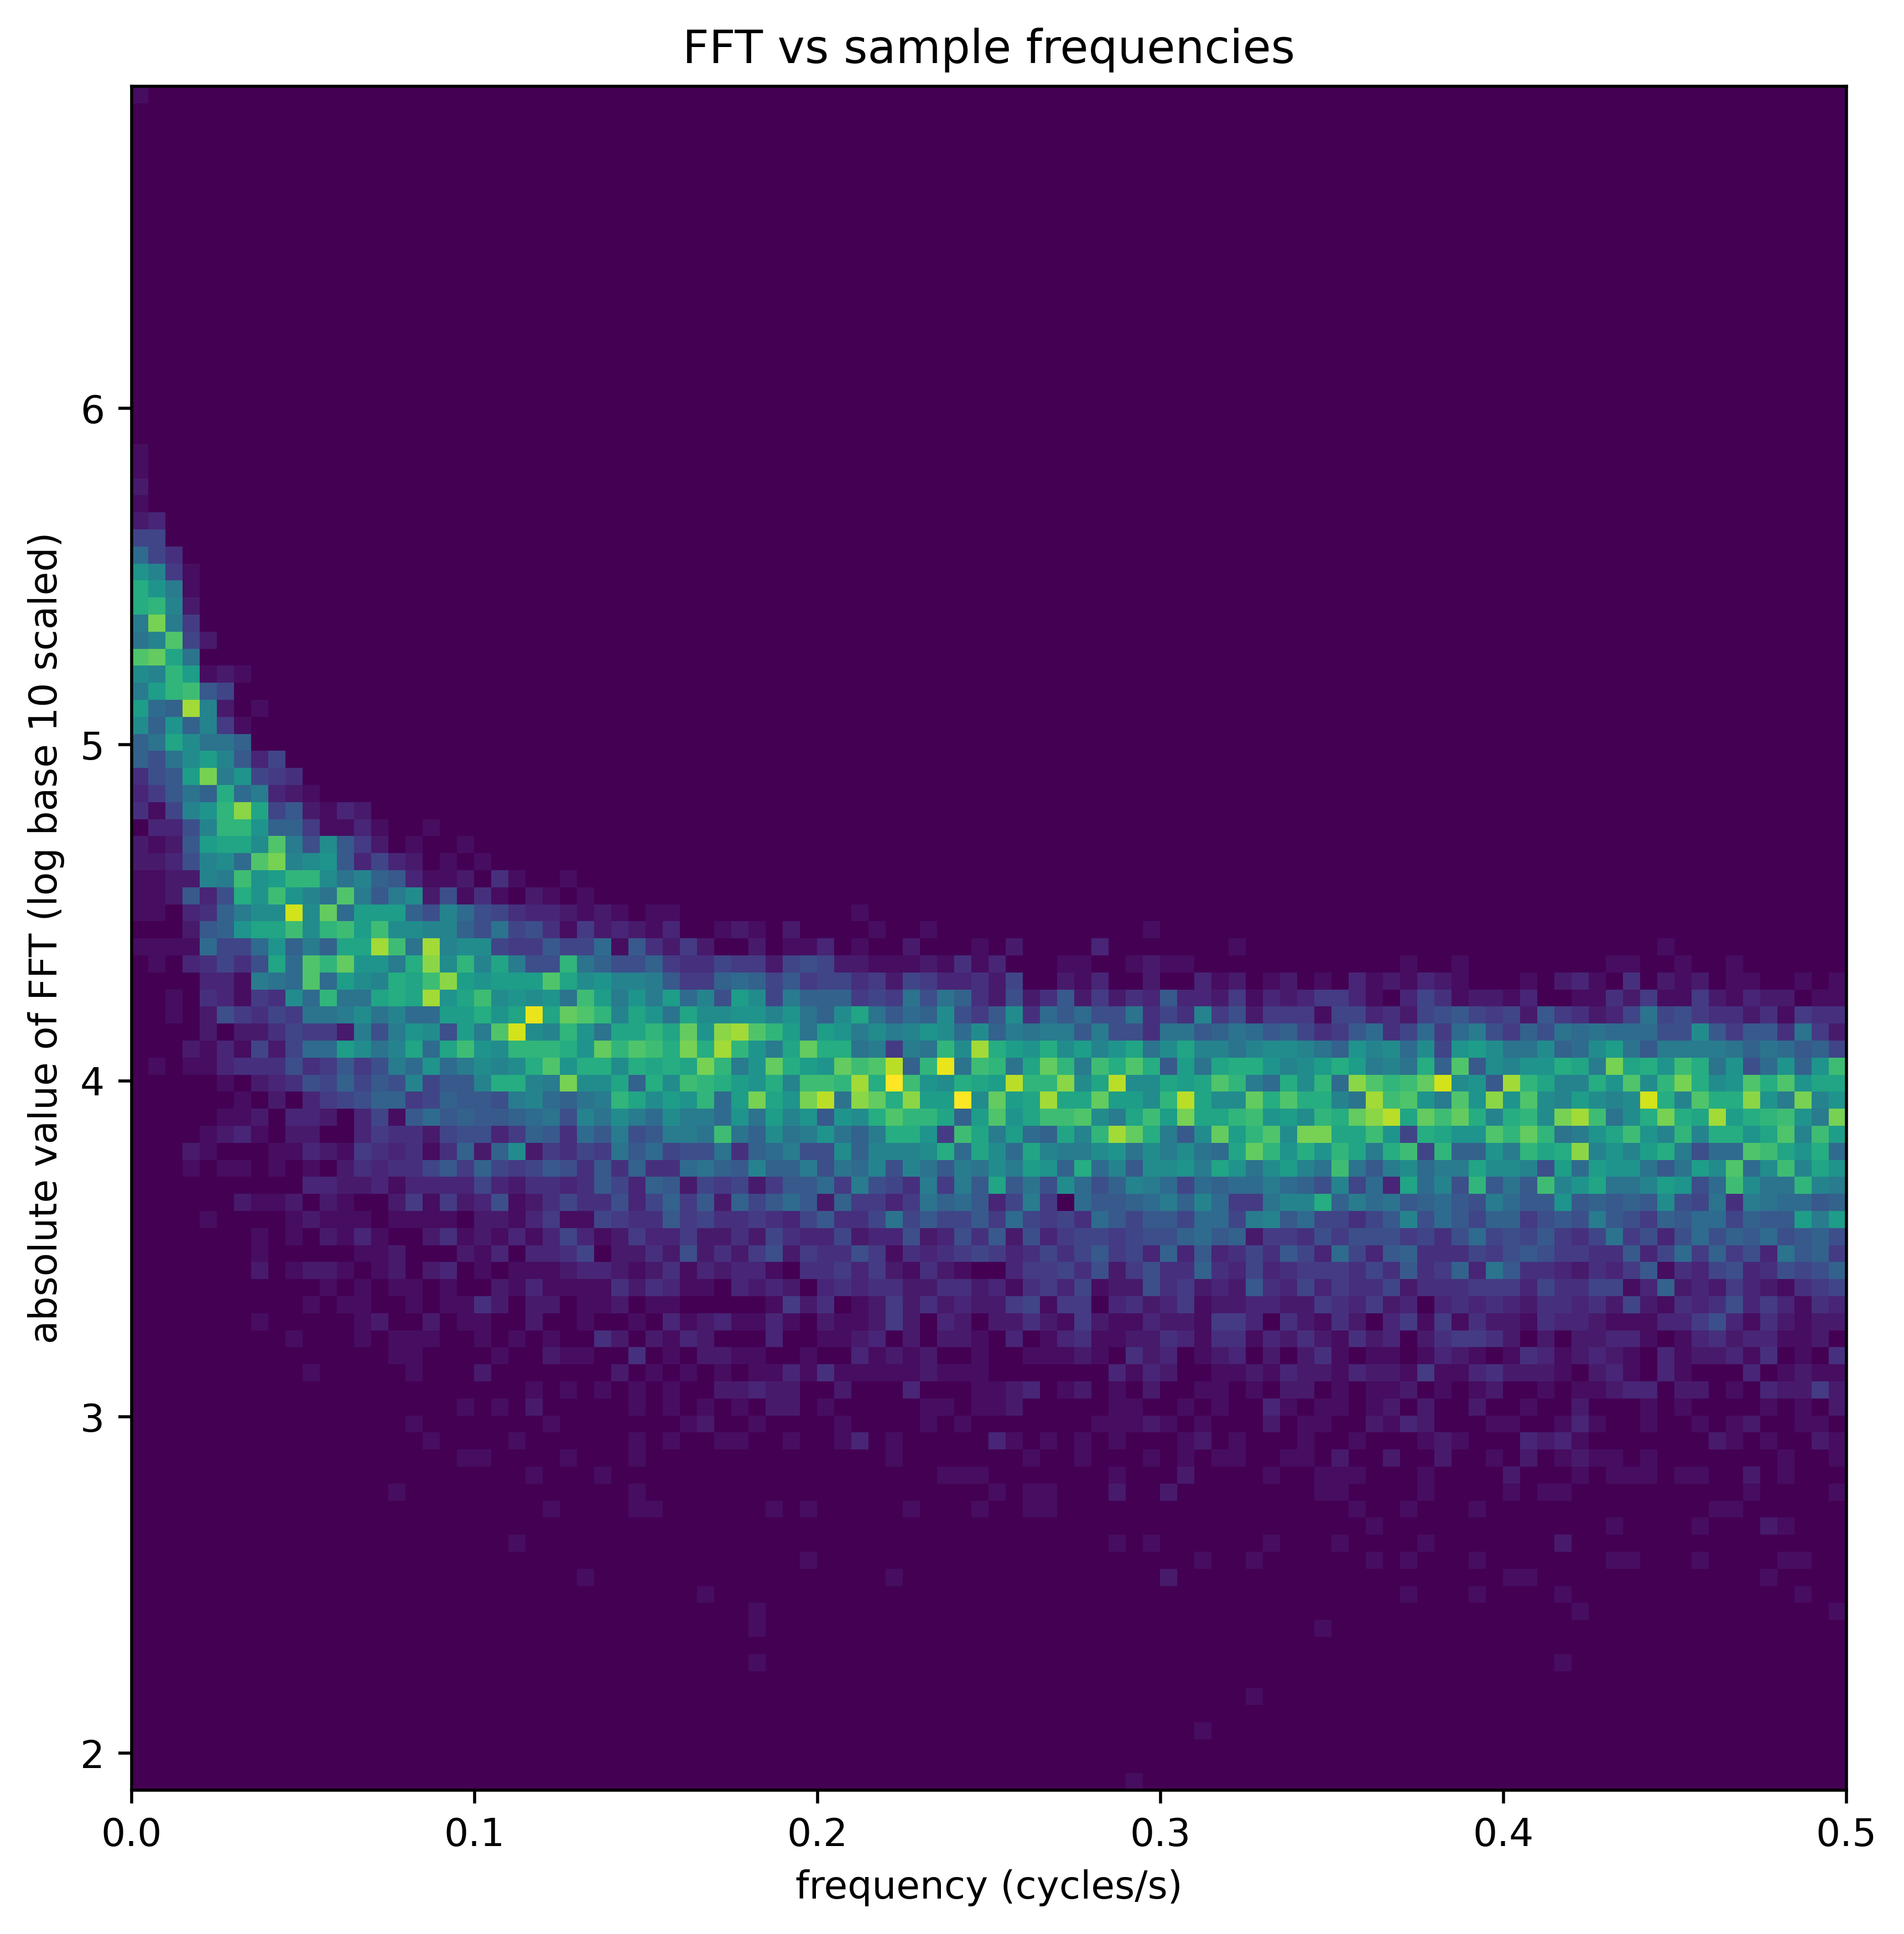

In [12]:
# %%capture 

plt.style.use('default')

plt.figure(figsize=(8,8),dpi=500)
plt.hist2d(freqs, np.lib.scimath.log10(abs(FFT)), bins=100)
plt.xlabel('frequency (cycles/s)')
plt.ylabel('absolute value of FFT (log base 10 scaled)')
plt.title('FFT vs sample frequencies')
# plt.savefig(unique_user_saved_outputs+'/plots/fft_of_dnm2_signals.png', bbox_inches='tight')

# filter out all DNM2 traces where frequencies are greater than 0.2 cycles/second (greater than 5 second oscillations)

In [19]:
sos = signal.butter(4, 0.1, 'lp', fs=1, output='sos') # low-pass 4-th order Butterworth filter

filtered_amplitudes_arpc3_negative = [] # filtered DNM2 traces per track of interest
filtered_amplitudes_arpc3_positive = []

for i in range(len(ap2_amplitudes_arpc3_negative)):

    raw_intensity = ap2_amplitudes_arpc3_negative[i]
    
    # add zeros to end to account for phase shift of near-track-end peaks
    filtered_amplitudes_arpc3_negative.append(list(list(signal.sosfilt(sos, raw_intensity)) + [0, 0, 0, 0, 0])) 
    
for i in range(len(ap2_amplitudes_arpc3_positive)):

    raw_intensity = ap2_amplitudes_arpc3_positive[i]
    
    # add zeros to end to account for phase shift of near-track-end peaks
    filtered_amplitudes_arpc3_positive.append(list(list(signal.sosfilt(sos, raw_intensity)) + [0, 0, 0, 0, 0])) 

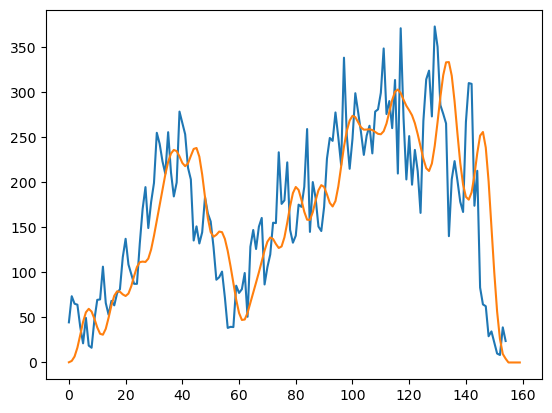

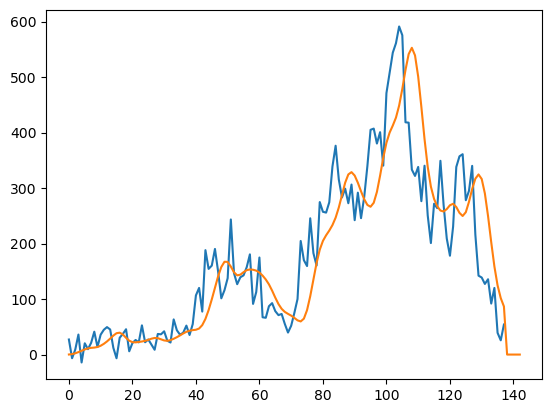

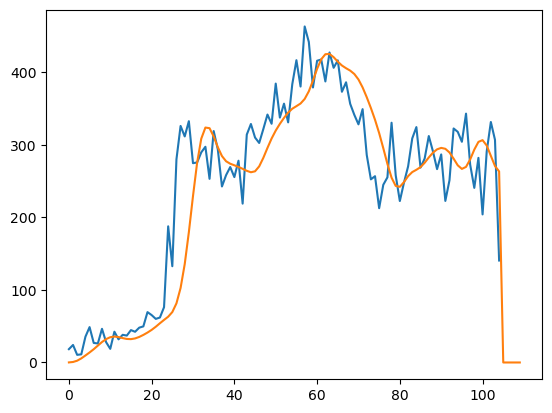

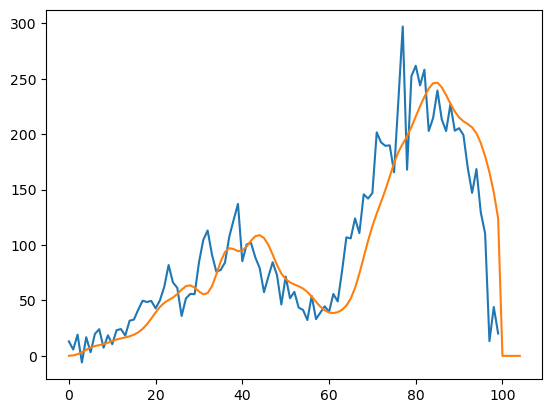

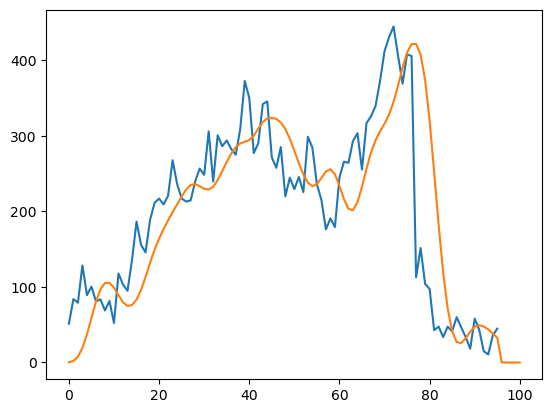

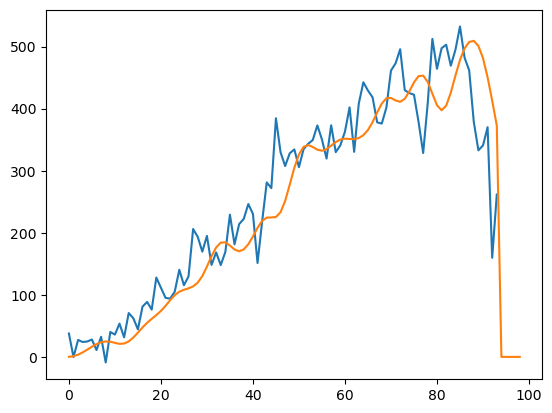

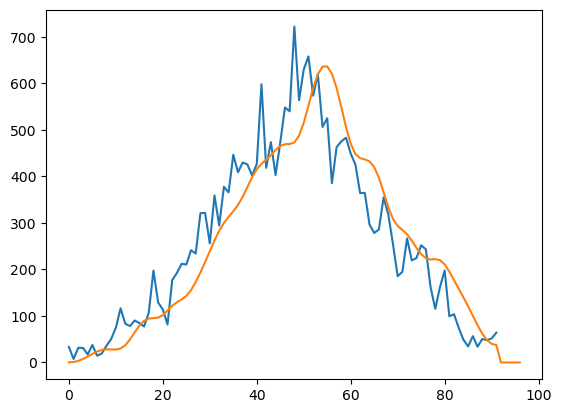

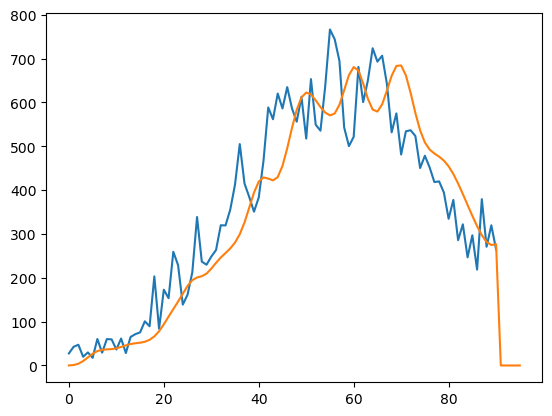

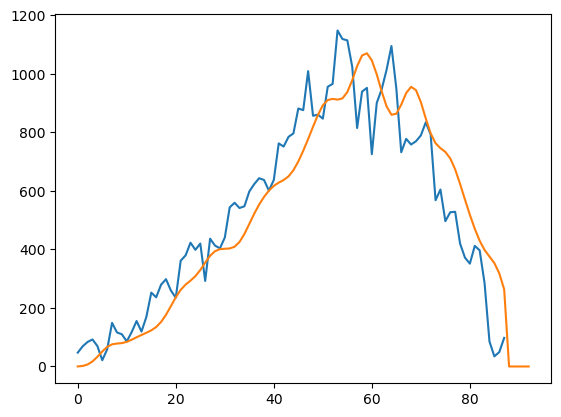

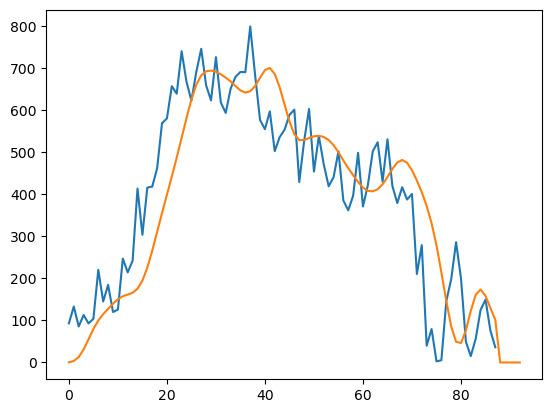

In [20]:
for i in range(10):
    
    plt.plot(ap2_amplitudes_arpc3_negative[i])
    plt.plot(filtered_amplitudes_arpc3_negative[i])
    plt.show()

In [21]:
percent_threshold = np.arange(70,100,5)

data_df = []

# detections_above_threshold_arpc3_negative = []
# detections_above_threshold_arpc3_positive = []

# coordinates_x_scatter_plot_arpc3_negative = []
# coordinates_x_scatter_plot_arpc3_positive = []

for threshold in percent_threshold:

    for i in range(len(ap2_amplitudes_arpc3_negative)):

        current_amp = filtered_amplitudes_arpc3_negative[i]

        idx_max = time_ap2_appearance_to_dnm2_peak_arpc3_negative[i]

        amp_max = current_amp[idx_max]
        
        amps_before_max = current_amp[0:idx_max]
    
        num_detections_early = len(np.where(amps_before_max>(amp_max*threshold/100))[0])
        
#         coordinates_x_scatter_plot_arpc3_negative.append(threshold)
        
#         detections_above_threshold_arpc3_negative.append(num_detections_early)
        
        data_df.append([threshold, num_detections_early, 0])
        
    for i in range(len(ap2_amplitudes_arpc3_positive)):

        current_amp = filtered_amplitudes_arpc3_positive[i]

        idx_max = time_ap2_appearance_to_dnm2_peak_arpc3_positive[i]

        amp_max = current_amp[idx_max]
        
        amps_before_max = current_amp[0:idx_max]
    
        num_detections_early = len(np.where(amps_before_max>(amp_max*threshold/100))[0])
        
#         coordinates_x_scatter_plot_arpc3_positive.append(threshold)
        
#         detections_above_threshold_arpc3_positive.append(num_detections_early)
        
        data_df.append([threshold, num_detections_early, 1])

In [22]:
df_merged = pd.DataFrame(data=data_df, columns=['threshold',
                                                'detections',
                                                'condition'])

(0.0, 100.0)

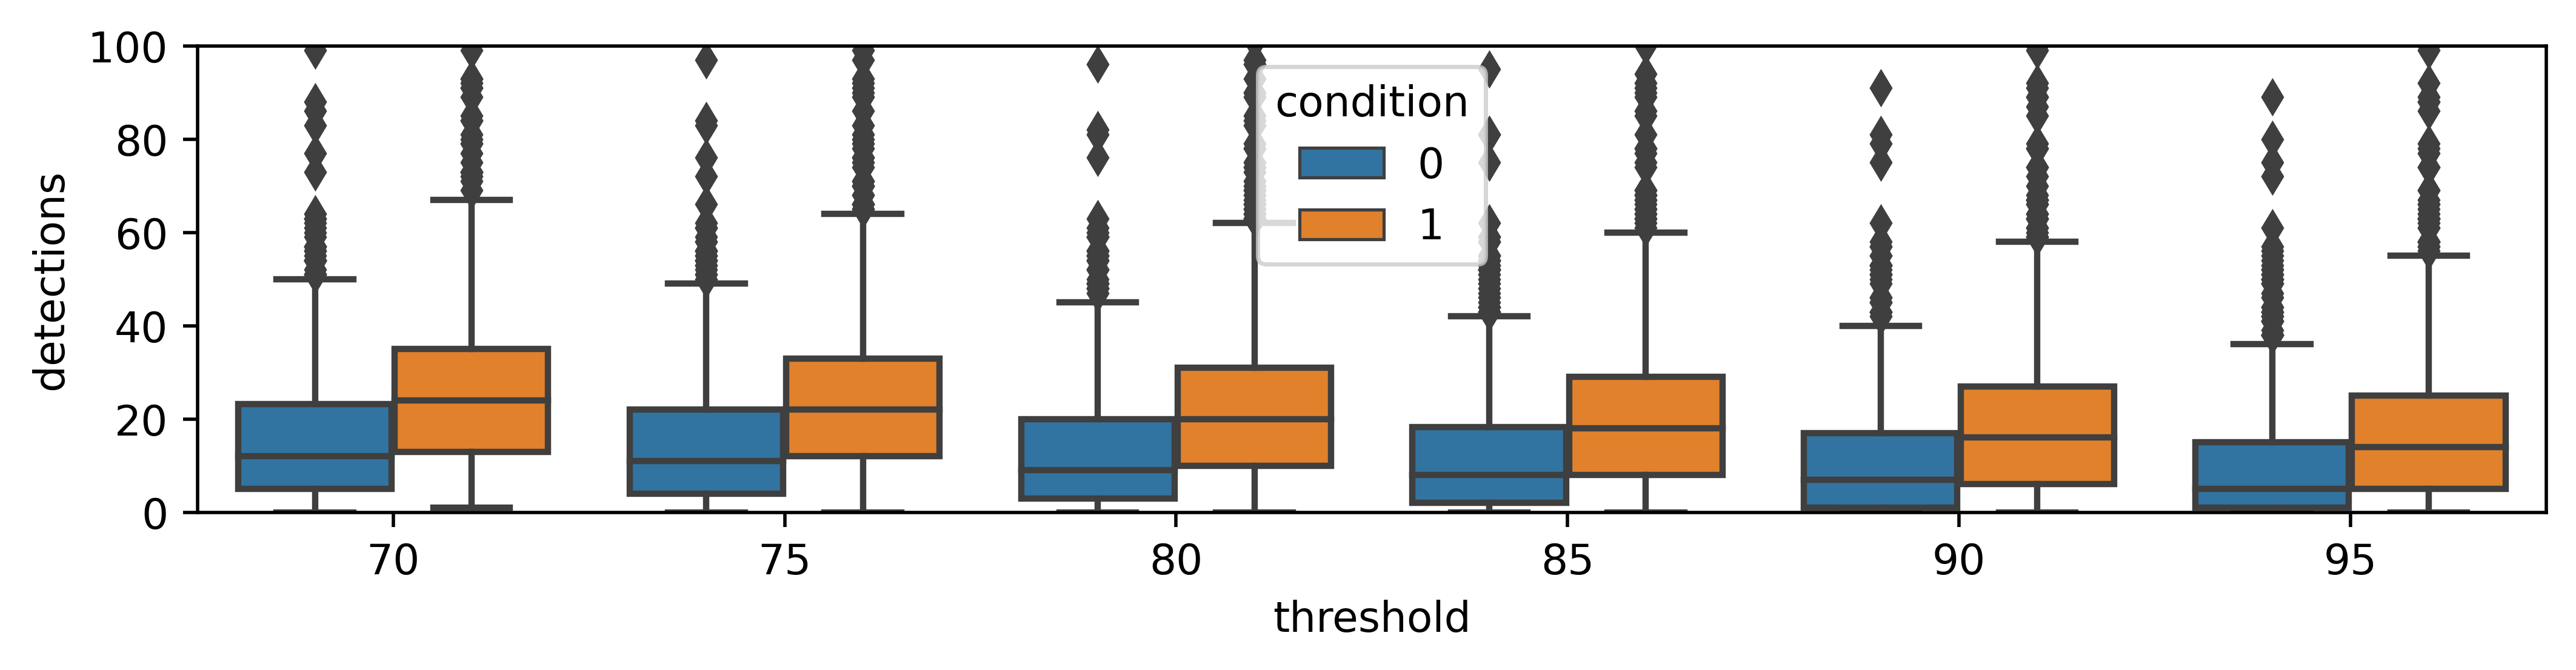

In [24]:
plt.rcParams['figure.dpi']=500
plt.rcParams['figure.figsize']=(10,2)
sns.boxplot(data=df_merged,
            x='threshold',
            y='detections',
            hue='condition')
plt.ylim(0,100)
# plt.xlim([70,90])
# plt.ylim([0,30])

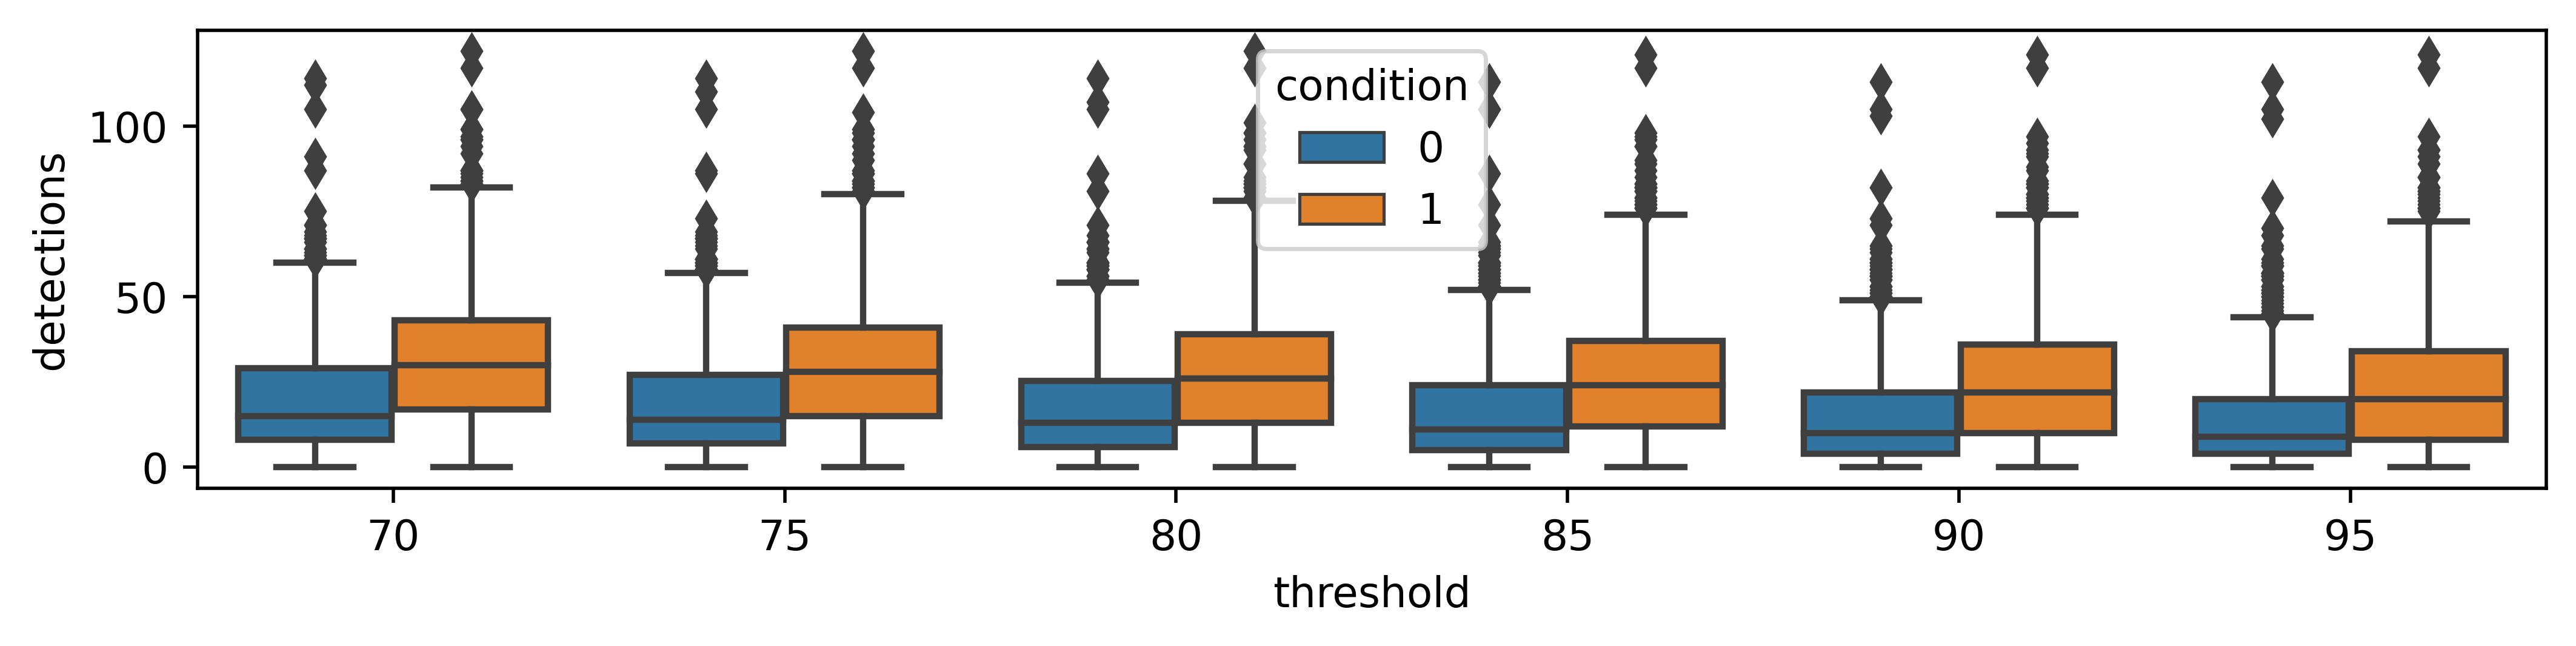

In [14]:
plt.rcParams['figure.dpi']=500
plt.rcParams['figure.figsize']=(10,2)
sns.boxplot(data=df_merged,
            x='threshold',
            y='detections',
            hue='condition')
# plt.xlim([70,90])
# plt.ylim([0,30])

(0.0, 5.0)

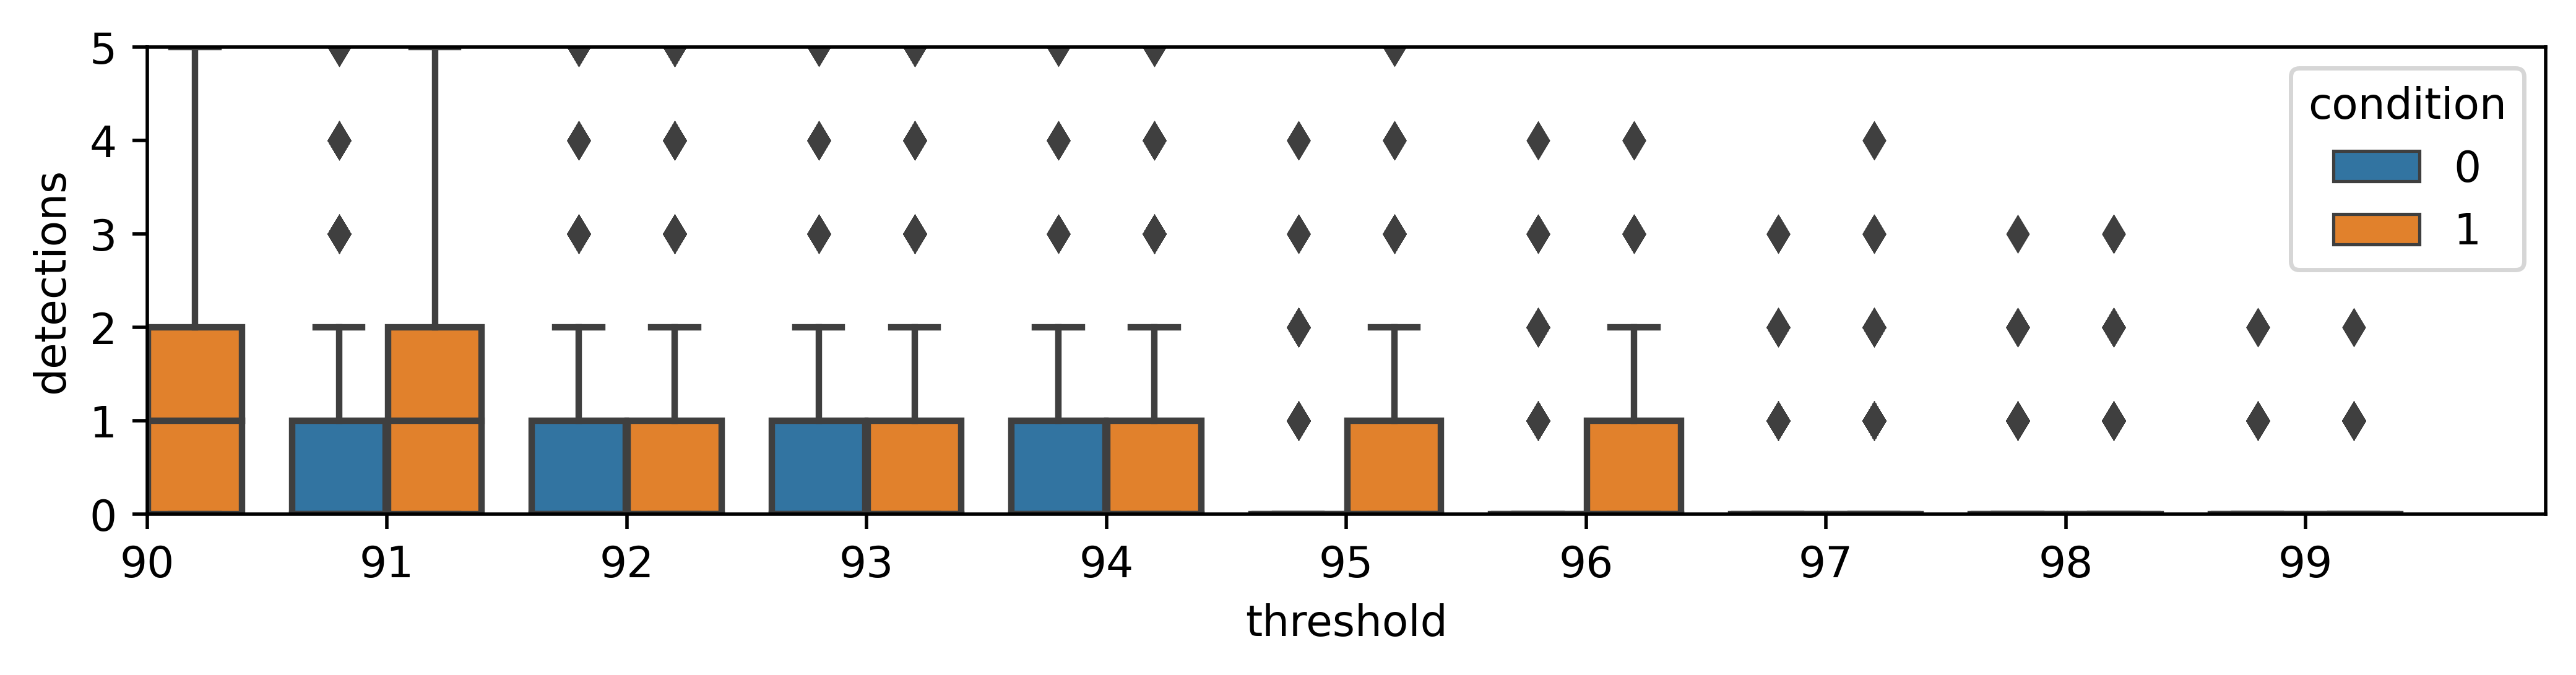

In [40]:
plt.rcParams['figure.dpi']=500
plt.rcParams['figure.figsize']=(10,2)
sns.boxplot(data=df_merged,
            x='threshold',
            y='detections',
            hue='condition')
plt.xlim([90,100])
plt.ylim([0,5])

### len(coordinates_x_scatter_plot_arpc3_positive), len(detections_above_threshold_arpc3_positive)

In [11]:
import matplotlib as mpl

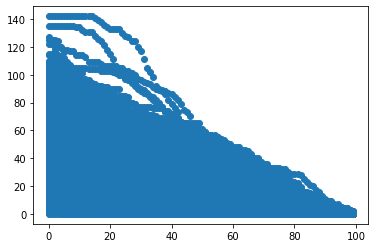

In [19]:
plt.scatter(coordinates_x_scatter_plot_arpc3_positive,
           detections_above_threshold_arpc3_positive, 
           )

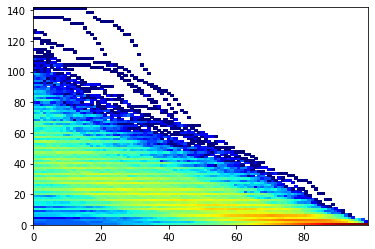

In [21]:
plt.hist2d(coordinates_x_scatter_plot_arpc3_positive,
           detections_above_threshold_arpc3_positive, 
           bins=100,
           norm=mpl.colors.LogNorm(),
           alpha=1,
           density=True,
           cmap='jet');

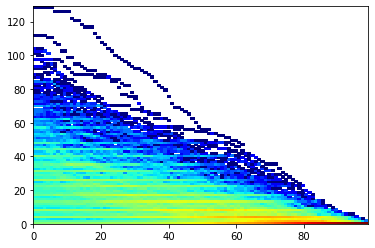

In [22]:
plt.hist2d(coordinates_x_scatter_plot_arpc3_negative,
           detections_above_threshold_arpc3_negative, 
           bins=100,
           norm=mpl.colors.LogNorm(),
           alpha=1,
           density=True,
           cmap='jet');